# Volatilidad implícita
## Introducción


Pensemos en un activo cualquiera, este activo refleja una varianza histórica que podemos observar y medir.

Este activo puede ser subjacente de distintos tipos de derivados y como bien sabemos esto significa que el precio de estos dependerá de las distintas caracteristicas de nuestro subjacente.

In [2]:

%pip install yfinance

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
import scipy.stats as stats


  Using cached yfinance-0.2.66-py2.py3-none-any.whl.metadata (6.0 kB)
  Using cached multitasking-0.0.12.tar.gz (19 kB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
     ---------------------------------------- 0.0/3.0 MB ? eta -:--:--
     -------------------------------------- - 2.9/3.0 MB 23.8 MB/s eta 0:00:01
     ---------------------------------------- 3.0/3.0 MB 22.1 MB/s eta 0:00:00
  Installing build dependencies: started
  Installing build dependencies: finished with status 'done'
  Getting requirements to build wheel: started
  Getting requirements to build wheel: finished with status 'done'
  Preparing metadata (pyproject.toml): started
  Preparing metadata (pyproject.toml): finished with status 'done'
  Using cached curl_cffi-0.13.0-cp39-abi3-win_amd64.whl.metadata (13 kB)
  Using cached websockets-15.0.1-cp312-cp312-win_amd64.whl.metadata (7.0 kB)
Using cached yfinance-0.2.66-py2.py3-none-any.whl (123 kB)
Using cac

In [21]:

ticker = yf.Ticker('AAPL')
prices = ticker.history(period="2y")['Close']
calls = ticker.option_chain(ticker.options[0]).calls


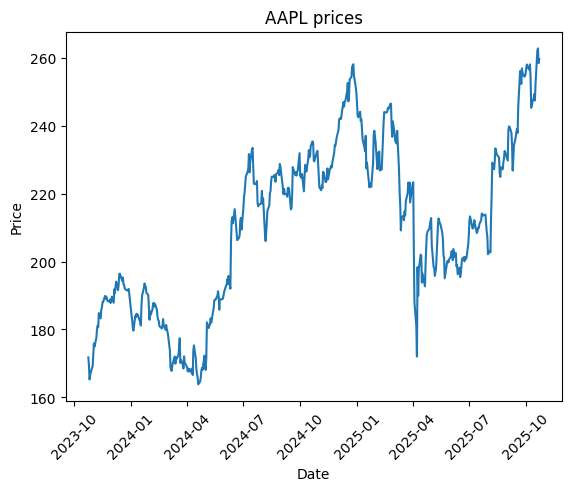

In [29]:
plt.plot(prices)
plt.title(f"{ticker.ticker} prices")
plt.xticks(rotation=45)
plt.xlabel("Date")
plt.ylabel("Price")
plt.show()

In [32]:
current_price = prices.iloc[-1]
print("current price:",current_price)

current price: 259.5799865722656


Viendo el precio actual del activo y el histórico haga una estimacion vaga del precio de las siguientes opciones.

In [50]:
k=5
print(f"Expiration date: {ticker.options[0]}")
mask =(calls['strike']<=(current_price+k)) & (calls['strike']>=(current_price-k))
masked_calls = calls[mask][['contractSymbol','strike']]
masked_calls

Expiration date: 2025-10-24


,contractSymbol,strike
32,AAPL251024C00255000,255.0
33,AAPL251024C00257500,257.5
34,AAPL251024C00260000,260.0
35,AAPL251024C00262500,262.5


Podriamos usar otras herramisntas a nuestra dispocision para tener mas informacion y mejorar nuestra estimacion. Por ejemplo podemos calcular la probabilidad de que se ejecuten.

Si queremos calcular la probabilidad de que se ejecuten tenemos que usar el modelo
$$dS=S_0 \mu dt + S_0 \sigma dW$$

In [63]:
S_0 = current_price
mu = prices.pct_change().mean()
sigma = prices.pct_change().std()
t = (dt.datetime.today()-dt.datetime.strptime(ticker.options[0], "%Y-%m-%d")).days + 1
print(f"S_0: {current_price}")
print(f"mu: {mu}")
print(f"sigma: {sigma}")
print(f"dt: {t}")

S_0: 259.5799865722656
mu: 0.0009797456897589047
sigma: 0.01771680003805864
dt: 1


Sabemos que el valor esperado del cambio en el precio del activo es

$$E[dS]=S_0 \mu dt$$

y la varianza esta dada por

$$Var[dS]= S_0^2 \sigma^2 dt$$


In [66]:
E = S_0*mu*t
Var = S_0**2*sigma**2*t
print(f"E[dS]: {E}")
print(f"Var[dS]: {Var}")

E[dS]: 0.2543223729918516
Var[dS]: 21.15012693898013


Con las siguientes probabilidades, ajusta tus estimaciones de cuanto crees que sea la prima de estas opciones call.

In [73]:
K = masked_calls['strike'].values
masked_calls['execution probability']=1-stats.norm.cdf((K-current_price),E,Var**0.5)
masked_calls

,contractSymbol,strike,execution probability
32,AAPL251024C00255000,255.0,0.853412
33,AAPL251024C00257500,257.5,0.694125
34,AAPL251024C00260000,260.0,0.485630
35,AAPL251024C00262500,262.5,0.281081



### Precio justo de una opción (Black Scholes)

una herramienta mas potente para estimar el precio de las primas puede ser encontrar el precio justo usando black scholes

$$C(S, t) = S \cdot N(d_1) - K e^{-r(T-t)} \cdot N(d_2)$$

$$d_1 = \frac{\ln\left(\frac{S}{K}\right) + \left(r + \frac{\sigma^2}{2}\right)(T-t)}{\sigma\sqrt{T-t}}$$

$$d_2 = d_1 - \sigma\sqrt{T-t}
$$


In [86]:
r = (1+0.071)**(1/255)-1
d1 = (np.log(S_0/K) + (r + sigma**2/2)*t)/(sigma*t**0.5)
d2 = d1 - sigma*t**0.5
C = S_0*stats.norm.cdf(d1) - K*np.exp(-r*t)*stats.norm.cdf(d2)
masked_calls['fair price'] = C
masked_calls

,contractSymbol,strike,execution probability,fair price
32,AAPL251024C00255000,255.0,0.853412,5.014073
33,AAPL251024C00257500,257.5,0.694125,3.099280
34,AAPL251024C00260000,260.0,0.485630,1.666191
35,AAPL251024C00262500,262.5,0.281081,0.759595


Con esta nueva informacion ajusta una ultima vez tus estimaciones de las primas.

Para este punto habran notado que el precio de la prima baja cuando las opciones son mas riesgosas y sube cuando son mas seguras, por lo que haciendo de lado variables que no podemos cambiar como el intervalo de tiempo, el precio del activo o la tasa libre de riesgo, el precio de la prima de una opcion se puede ver como una funcion de la varianza (o volatilidad) del activo.

En el mercado podemos observar las siguientes primas `lastPrice` que son cercanas pero distintas al precio justo que calculamos. Ahora pregúntate:

Qué tan cercana fue tu estimación?
A qué crees que se deba la diferencia entre el precio justo y la prima que vemos en el mercado?



In [88]:
calls[mask]

,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
32,AAPL251024C00255000,2025-10-23 19:59:09+00:00,255.0,4.89,4.80,5.00,0.44,9.887643,4183,26222,0.351569,True,REGULAR,USD
33,AAPL251024C00257500,2025-10-23 19:59:56+00:00,257.5,2.74,2.72,2.83,0.04,1.481480,18794,10697,0.291999,True,REGULAR,USD
34,AAPL251024C00260000,2025-10-23 19:59:54+00:00,260.0,1.20,1.20,1.24,-0.22,-15.492951,63293,26178,0.265632,False,REGULAR,USD
35,AAPL251024C00262500,2025-10-23 19:59:58+00:00,262.5,0.37,0.36,0.40,-0.34,-47.887320,38889,20189,0.257332,False,REGULAR,USD


La diferencia se debe a que en el mercado los precios de los derivados no son fijos, estan sujetos a movimientos segun su oferta y demanda.

Otra forma de ver esto es que el precio de la prima refleja la expectativa que el mercado tiene de la volatilidad en el periodo de la opcion.

Y si podemos calcular la prima en funcion a la volatilidad (Black Scholes), eso quiere decir que tambien podemos ver la volatilidad en funcion de la prima.

Para hacer esto podemos utilizar BS y metodos numericos:

In [90]:


from scipy.optimize import brentq

K=257.5
def BS(sigma):
  d1=(np.log(S_0/K)+(r+sigma**2/2)*t)/(sigma*np.sqrt(t))
  d2=d1-sigma*np.sqrt(t)
  c=S_0*stats.norm.cdf(d1)-K*np.exp(-r*t)*stats.norm.cdf(d2)
  return c

def objective(sigma):
    return BS(sigma) - 2.74

implied_vol = brentq(objective, -0.01, 0.07, xtol=1e-6)
print(f"La volatilidad implícita es: {implied_vol:.6f}  vs {sigma}")



La volatilidad implícita es: 0.013701  vs 0.01771680003805864


## Tarea

Comparar la volatilidad implicita de un grupo de opciones de un activo. con la varianza observada en dicho periodo.

Para lograr esto tenemos que calcular la volatilidad implicita de las opciones hoy, guardar esta informacion y regresar despues del vencimiento pera calcular la volatilidad del activo desde hoy hasta la fecha de vencimiento, compara con distintos timeframes y reflexiona sobre los resultados encontrados.

In [139]:
ticker = yf.Ticker('NXPI')
expiry = ticker.options[1]
print(f"Ticker: {ticker.ticker}")
print(f"Expiry: {expiry}")
options = ticker.option_chain(expiry).calls
prices = ticker.history(period="2y")['Close']
last_price = prices.iloc[-1]
print(f"Last price: {last_price}")
margin = 5
options = options[(options['strike']>=last_price-margin) & (options['strike']<=last_price+margin)]
options

Ticker: NXPI
Expiry: 2025-10-31
Last price: 220.72999572753906


,contractSymbol,lastTradeDate,strike,lastPrice,bid,ask,change,percentChange,volume,openInterest,impliedVolatility,inTheMoney,contractSize,currency
4,NXPI251031C00217500,2025-10-23 17:58:53+00:00,217.5,8.92,8.9,9.7,0.42,4.941177,5.0,56,0.585575,True,REGULAR,USD
5,NXPI251031C00220000,2025-10-23 19:37:56+00:00,220.0,8.28,7.7,8.3,0.88,11.891887,111.0,170,0.586430,True,REGULAR,USD
6,NXPI251031C00222500,2025-10-23 14:21:56+00:00,222.5,5.80,6.2,7.1,-0.60,-9.374999,3.0,206,0.573246,False,REGULAR,USD
7,NXPI251031C00225000,2025-10-23 19:38:25+00:00,225.0,5.70,5.1,6.0,0.20,3.636360,8.0,31,0.569340,False,REGULAR,USD


In [142]:
from scipy.optimize import brentq
import datetime as dt
import scipy.stats as stats
S_0 = last_price
mu = prices.pct_change().mean()
t = (dt.datetime.strptime(expiry, "%Y-%m-%d")-dt.datetime.today()).days + 2
r = (1+0.071)**(1/255)-1
print(f"S_0: {S_0}")
print(f"mu: {mu}")
print(f"dt: {t}")
print(f"expiry: {expiry}")
for K, l in zip(options['strike'], options['lastPrice']):
  def BS(sigma):
    d1=(np.log(S_0/K)+(r+sigma**2/2)*t)/(sigma*np.sqrt(t))
    d2=d1-sigma*np.sqrt(t)
    c=S_0*stats.norm.cdf(d1)-K*np.exp(-r*t)*stats.norm.cdf(d2)
    return c

  def objective(sigma):
      return BS(sigma) - l

  implied_vol = brentq(objective, -0.01, 0.07, xtol=1e-6)
  print(f"La volatilidad implícita para strike en {K} es: {implied_vol:.6f}")


S_0: 220.72999572753906
mu: 0.0007684351238913867
dt: 8
expiry: 2025-10-31
La volatilidad implícita para strike en 217.5 es: 0.028004
La volatilidad implícita para strike en 220.0 es: 0.030863
La volatilidad implícita para strike en 222.5 es: 0.025727
La volatilidad implícita para strike en 225.0 es: 0.029628


## Volatilidad de 28/10/2025.

| Strike | Volatilidad Implícita |
| ------ | --------------------- |
| 217.5  | 0.028004              |
| 220.0  | 0.030863              |
| 222.5  | 0.025727              |
| 225.0  | 0.029628              |


## Calculamos volatilidad observada hasta hoy

C:\Users\luis ramon\AppData\Local\Temp\ipykernel_3336\3041191541.py:15: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download("NXPI", start=inicio, end=fin)
[*********************100%***********************]  1 of 1 completed
C:\Users\luis ramon\AppData\Local\Temp\ipykernel_3336\3041191541.py:22: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vol_obs = float(returns.std())
C:\Users\luis ramon\AppData\Local\Temp\ipykernel_3336\3041191541.py:50: FutureWarning: YF.download() has changed argument auto_adjust default to True
  hist = yf.download("NXPI", period="6mo")['Close']


Volatilidad observada (diaria) del 2025-10-28 al 2025-10-31: 0.033162

Comparación de volatilidades:
   Strike  Vol. Implícita (28 oct)  Vol. Observada (28-31 oct)  Diferencia (%)
0   217.5                 0.028004                    0.033162       18.417259
1   220.0                 0.030863                    0.033162        7.447653
2   222.5                 0.025727                    0.033162       28.897925
3   225.0                 0.029628                    0.033162       11.926452


[*********************100%***********************]  1 of 1 completed
C:\Users\luis ramon\AppData\Local\Temp\ipykernel_3336\3041191541.py:57: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  vol = float(rets.tail(v).std())



Volatilidades observadas en distintos timeframes:
   Ventana (días)  Vol. Observada (diaria)
0               7                 0.022922
1              14                 0.020072
2              30                 0.024778
3              60                 0.023241
4              90                 0.021381


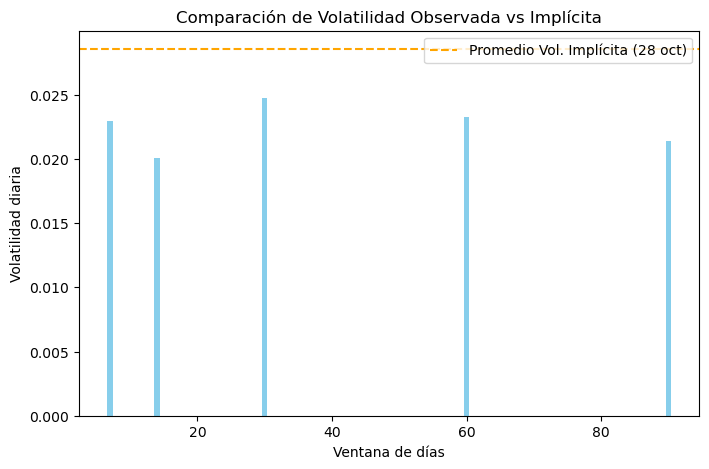

In [ ]:

import yfinance as yf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Fechas del análisis: desde el 28 de octubre (día del cálculo de VI) hasta el 31 de octubre (vencimiento)
inicio = "2025-10-28"
fin = "2025-10-31"

# Descargamos precios del activo en ese periodo
data = yf.download("NXPI", start=inicio, end=fin)
data

# Calculamos rendimientos y volatilidad observada
returns = data['Close'].pct_change().dropna()

# Convertimos la desviación estándar a float
vol_obs = float(returns.std())

print(f"Volatilidad observada (diaria) del {inicio} al {fin}: {vol_obs:.6f}")

# ===========================
# Comparación con volatilidades implícitas del 28 de octubre
# ===========================
vol_impl = {
    217.5: 0.028004,
    220.0: 0.030863,
    222.5: 0.025727,
    225.0: 0.029628
}

# Creamos DataFrame comparativo
comp = pd.DataFrame({
    'Strike': list(vol_impl.keys()),
    'Vol. Implícita (28 oct)': list(vol_impl.values())
})
comp['Vol. Observada (28-31 oct)'] = vol_obs
comp['Diferencia (%)'] = 100 * (comp['Vol. Observada (28-31 oct)'] - comp['Vol. Implícita (28 oct)']) / comp['Vol. Implícita (28 oct)']

print("\nComparación de volatilidades:")
print(comp)

# ===========================
# Análisis en distintos timeframes (observados)
# ===========================
hist = yf.download("NXPI", period="6mo")['Close']
rets = hist.pct_change().dropna()

ventanas = [7, 14, 30, 60, 90]
vols = []

for v in ventanas:
    vol = float(rets.tail(v).std())
    vols.append(vol)

df_vols = pd.DataFrame({'Ventana (días)': ventanas, 'Vol. Observada (diaria)': vols})
print("\nVolatilidades observadas en distintos timeframes:")
print(df_vols)

# ===========================
# Gráfica comparativa
# ===========================
plt.figure(figsize=(8,5))
plt.bar(df_vols['Ventana (días)'], df_vols['Vol. Observada (diaria)'], color='skyblue')
plt.axhline(y=np.mean(list(vol_impl.values())), color='orange', linestyle='--', label='Promedio Vol. Implícita (28 oct)')
plt.title("Comparación de Volatilidad Observada vs Implícita")
plt.xlabel("Ventana de días")
plt.ylabel("Volatilidad diaria")
plt.legend()
plt.show()


# Reflexiones 

Para complementar el análisis de la volatilidad observada entre el 28 y el 31 de octubre, se incorporaron también periodos de 7, 14, 30, 60 y 90 días. Estas ventanas permiten observar cómo cambia la volatilidad según el horizonte temporal y ofrecen una perspectiva más amplia sobre el comportamiento del activo. La ventana de 7 días representa una semana de operación, muy sensible a cambios recientes; las de 14 y 30 días muestran tendencias de corto y mediano plazo; mientras que las de 60 y 90 días reflejan la estabilidad del activo en horizontes más largos. Este enfoque ayuda a contextualizar si los movimientos recientes fueron atípicos o consistentes con la tendencia histórica.

Durante el periodo del 28 al 31 de octubre, la volatilidad observada diaria fue de 0.0332, superior a todas las volatilidades implícitas estimadas el 28 de octubre, que variaban entre 0.0257 y 0.0309. Esto indica que el mercado subestimó la volatilidad real, ya que las expectativas reflejadas en las opciones fueron más bajas que la variabilidad efectivamente registrada. En comparación con los distintos timeframes históricos, las volatilidades observadas en ventanas de 7 a 90 días (entre 0.020 y 0.025) resultaron menores, lo que confirma que la semana del vencimiento fue un periodo inusualmente volátil.

En general, los resultados muestran que la volatilidad real fue más alta de lo que el mercado esperaba y también mayor que la que se había visto en los meses anteriores. Esto refleja que en esos días hubo un aumento momentáneo del riesgo. Por eso es útil analizar la volatilidad en diferentes periodos, para poder distinguir si un cambio fuerte es algo temporal o parte de una tendencia más constante en el comportamiento del activo.